# Blackjack Agent using Deep-Q Learning
In this notebook, we aim to train an agent to play the Blackjack via the use of reinforcement learning (Deep-Q Learning). We will treat the process of walking as a Markov Decision Process (MDP) in our learning efforts.

# 1. Packages
`Xvfb` and `gym[Box2D]` are also required in order to run our display and the environment respectively.

In [1]:
import time
from collections import deque, namedtuple

import gym
import numpy as np
import PIL.Image
import tensorflow as tf

from pyvirtualdisplay import Display
from utils import *
from copy import deepcopy

In [2]:
# Virtual Display for rendering of the Bipedal Walker environment
Display(visible=0, size=(840, 480)).start();

# Random seed for tensorflow
tf.random.set_seed(0)

# 2. Blackjack Environment
We will [OpenAI's Gym library](https://www.gymlibrary.dev/) to load and attempt to solve the Blackjack environment. 

The goal of the Blakcjack environment is to train an agent to beat the dealer in Blackjack by obtaining cards that sum close to 21, without going over 21, and yet still have a higher value thant the dealer's card.

<br>
<br>
<figure>
  <img src ="https://www.gymlibrary.dev/_images/blackjack.gif" width = 40%>
      <figcaption style = "text-align: center; font-style: italic">Atari Environment</figcaption>
</figure>

## 2.1 Action Space
The action space consists of two actions represented by discrete values.
- `0`: Stick
- `1`: Hit

## 2.2 Observation Space
The agent's observation space is a state vector containing 3 variables:
1. Player's current sum `[int]`
2. Dealer's one showing card (1- 10) `[int]`
3. Whether a player holds a usable ace `[bool]`


## 2.3 Rewards
- Win game: +1
- Lose game: -1
- Draw: 0
- Win game with natural Blackjack: +1.5 if `natural=True`, else +1

# 3. Loading the Environement
We use the `gym` library to open the `BipedalWalker-v3` environment. `.reset()` resets the environment and `.render()` renders the first frame of the environment.

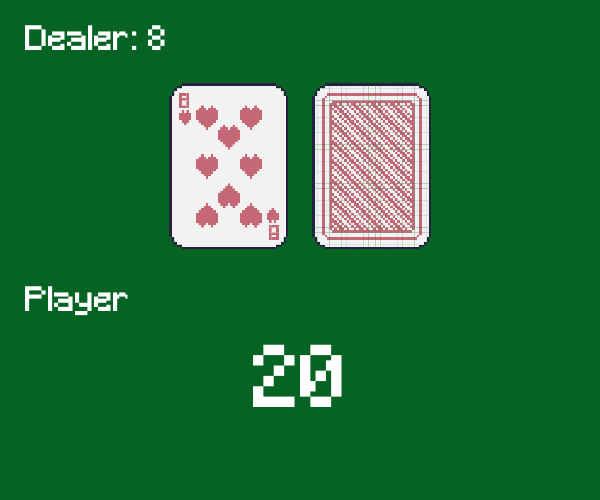

In [3]:
env = gym.make('Blackjack-v1', natural=True, sab=False, render_mode='rgb_array')
env.reset()

PIL.Image.fromarray(env.render())

Thereafter, we check the size of the state vector as well as the number of possible actions 

In [4]:
state_shape = len(env.observation_space)
poss_actions_space = env.action_space

print(f"State Vector: {state_shape}")
print(f"Poss Actions: {poss_actions_space}")

State Vector: 3
Poss Actions: Discrete(2)


In [5]:
poss_actions = 2

# 4. Dynamics of the Environment
Running `.step(action)` on the environment runs a single time step from the current state, $s$, taking action $a$ and returning different values. Here, we only care about:

1. `next_state` $(object)$: Observation of the environment after an action. This is a vector contain our Observation Space variables. We may sometimes denote this as $s'$

2. `rewards` $(float)$: Reward received as a result of our action. We may sometimes denote this as $R$

In [6]:
# Initial state of environment
init_state = env.reset()

# Sample action
action = 0

# Run a single time step given the action
next_state, reward, done, _, _ = env.step(action)

env.step(action)

((10, 10, False), -1.0, True, False, {})

In [7]:
init_state

((10, 10, False), {})

In [8]:
display_table(init_state, action, next_state, reward, done)

Initial State:,"((10, 10, False), {})"
Action:,S
Next State:,"(10, 10, False)"
Reward Received:,-1.000
Episode Terminated:,True


# 5. Deep $Q$-Learning
## 5.1 $Q$ Function
Our $Q$ function takes in 2 inputs -- $s$ and $a$, the current state and the action taken from this state. $Q(s, a)$ in this case is the total return for taking action $a$, arriving at state $s'$, and performing optimal actions from then on. We formulate $Q(s, a)$ using the Bellman Equation as shown:

$$Q_{i+1}(s, a) = R + \gamma\ max_{a'}\ Q_{i}(s', a')$$

Whereby $\gamma$ is the discount factor. As $i \to \infty$, our $Q$ function converges to the optimal $Q^{*}$. Due to the continuous problem that we are facing, we are unable to explore the entire state-action space and instead make use of a neural network, denoted as the $Q$-network, to estimate $Q(s, a) \approx Q^{*}(s, a)$ via iteratively adjusting its weights using gradient descent.

The $Q^{*}$ function is then used to choose the action that maximises $Q^{*}(s, a)$ to gain the greatest reward

## 5.2 Target Network
Our error term is currently calculated as shown
$$
\overbrace{\underbrace{R + \gamma \max_{a'}Q(s',a'; w)}_{\rm {y~target}} - Q(s,a;w)}^{\rm {Error}}
$$

However, the constantly changing $y$ targets may lead to instabilities in this application of reinforcement learning. Therefore, we need a seperate NN to be calculating the $y$ targets, whose weights are updated at a significantly slower pace. We denote the target network's state-action function as $\hat{Q}$ and its weights as $w^{-}$. We update $w^{-}$  using a **soft update** as follows:

$$w^-\leftarrow \tau w + (1 - \tau) w^-$$

whereby $\tau < 1$. And our error is calculated as shown:

$$ \overbrace{\underbrace{R + \gamma \max_{a'}\hat{Q}(s',a'; w^-)}_{\rm {y~target}} - Q(s,a;w)}^{\rm {Error}} $$

## 5.3 Networks
Here, the networks for both the target network as well as the $Q$-network are built using `keras`. Our initial architecture is as follows:
1. `Input` layer: takes in `state_shape` as inpit
2. `Dense` layer: `8` units, `relu` activation
3. `Dense` layer: `8` units, `relu` activation
4. `Dense` layer: `poss_actions` units, `linear` activation

Furthermore, since each blackjack episode only lasts 1 - 3 states, we want to penalise more risky plays by having a lower discount factor $\gamma$.

We use the `Adam` optimizer here, and also initate our intiial parameters.

In [9]:
# HYPERPARAMETERS
ALPHA = 1e-3 # Learning rate
GAMMA = 0.33 # Discount factor
MEM_SIZE = 100000 # Memory buffer size
NUM_STEPS_FOR_UPDATE = 1 # Number of time steps before updating weights

In [10]:
# Q-network
q_network = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(state_shape)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(poss_actions, activation='linear')
])

# Target Network
target_network = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(state_shape)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(poss_actions, activation='linear')
])

# Optimiser
optimiser = tf.keras.optimizers.Adam(learning_rate=ALPHA)

Metal device set to: Apple M1 Pro


2023-01-20 18:12:37.695799: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-20 18:12:37.695921: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## 5.4 Experience Relay
**Experience Relay** is used to prevent consecutive time steps being used due to their higher correlation. This process consists of storing all our experiences, which are in the form $(s, a, R, s')$ in a **memory buffer**, which will be randomly sampled form in **mini-batches** that reduce runtime. We store each individual experienced as a `namedtuple`.

Experience relay will be applied later on while training the agent.

In [11]:
experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

## 5.5 Loss Function
We compute the loss using Mean Squared Error, and the error term will follow section 5.1 whereby $y$-target is obtained from the Target Network. One thing to note is that $y$ no longer follows the Bellman equation if the next step is at a **terminal state**.

$$
\begin{equation}
    y_j =
    \begin{cases}
      R_j & \text{if episode terminates at step  } j+1\\
      R_j + \gamma \max_{a'}\hat{Q}(s_{j+1},a') & \text{otherwise}\\
    \end{cases}       
\end{equation}
$$


In [12]:
def compute_loss(experiences, gamma, q_network, target_q_network):
    """ 
    Calculates the loss.
    
    Args:
      experiences: (tuple) tuple of ["state", "action", "reward", "next_state", "done"] namedtuples
      gamma: (float) The discount factor.
      q_network: (tf.keras.Sequential) Keras model for predicting the q_values
      target_q_network: (tf.keras.Sequential) Keras model for predicting the targets
          
    Returns:
      loss: (TensorFlow Tensor(shape=(0,), dtype=int32)) the Mean-Squared Error between
            the y targets and the Q(s,a) values.
    """
    # Unpack mini-batch
    states, actions, rewards, next_states, done_vals = experiences

    # Find Max Q^(s, a) using the Target Network's Q^ function
    max_qsa = tf.reduce_max(target_network(next_states), axis=-1)

    # Compute y-target
    y_targets = rewards + (1 - done_vals) * gamma * max_qsa

    # Get Q(s,a) values from the Q-network
    q_values = q_network(states)
    q_values = tf.gather_nd(q_values, tf.stack([tf.range(q_values.shape[0]),
                                               tf.cast(actions, tf.int32)], axis=1))
    
    # Compute loss
    loss = tf.keras.losses.MSE(y_targets, q_values)

    return loss




## 5.6 Function to Update Network Weights
A custom training loop is employed in order to update both the weights of the $Q$ and $\hat{Q}$. A soft-update as mentioned in 5.2 is used for $\hat{Q}$

In [13]:
@tf.function
def agent_learn(experiences, gamma):
    """
    Updates the weights of the Q networks.
    
    Args:
      experiences: (tuple) tuple of ["state", "action", "reward", "next_state"] namedtuples
      gamma: (float) The discount factor.
    
    """
    
    # Calculate the loss.
    with tf.GradientTape() as tape:
        loss = compute_loss(experiences, gamma, q_network, target_network)

    # Get the gradients of the loss with respect to the weights.
    gradients = tape.gradient(loss, q_network.trainable_variables)
    
    # Update the weights of the q_network.
    optimiser.apply_gradients(zip(gradients, q_network.trainable_variables))

    # update the weights of target network via (soft update.
    # Function from utils

    TAU = 1e-3
    update_target_network(q_network, target_network, TAU)

# 6. Agent Training
With the wide application of reinforcement learning in Blackjack with poor results, we try to beat the benchmark of a 40% win rate.

In [14]:
# Keep track of learning time
start = time.time()

# Time requirement for the env
max_num_timesteps = 3
NUM_EPISODES = 30000 # Our rough estimate of the number of episodes we need

# Requirement for how many trials to average
num_p_av = 5000

# Initial Epsilon for epsilon greedy policy
epsilon = 1.0

# Keeping track of point history
total_point_history = []

# Memory buffer, containing experience namedtuples
memory_buffer = deque(maxlen=MEM_SIZE)

# Wins/losses/draws
stats = {'wins': 0, 'losses': 0, 'draws': 0}

In [15]:
# Set initial target weights using q_network's weights
target_network.set_weights(q_network.get_weights())

# Iterate NUM_EPISODES times
for i in range(NUM_EPISODES):
  # Rest env and start from the initial state
    state = env.reset()[0]
    total_points = 0

  # Iterate max number of time steps
    for t in range(max_num_timesteps):

        # Choose action a from curr state using Epsilon Greedy Policy
        state = convert_bool(list(state))
        state_qn = np.expand_dims(state, axis=0) # Reshape to fit the q network
        q_values = q_network(state_qn) # Get Q(s, a) values given current state
        action = get_action(q_values, epsilon) # In Utils, use epsilon greedy policy
        
        # Take action a from current state
        next_state, reward, _, done, _ = env.step(action)
        
        # Store experience tupple (s, a, R, s') in memoru buffer
        memory_buffer.append(experience(state, action, reward, next_state, done))
        
        # Check if we've hit the appropriate t time steps
        # And if memory buffer has sufficient data points for minibatch
        update = check_update_conditions(t, NUM_STEPS_FOR_UPDATE, memory_buffer)
        
        if reward == 1.0 or reward == 1.5:
            stats['wins'] += 1
        
        elif reward == 0:
            stats['draws'] += 1
            
        else:
            stats['losses'] += 1
        
        if update:
            # MINIBATCH Sampling of memory buffer.
            # MINIBATCH_SIZE denoted in utils
            experiences = get_experiences(memory_buffer)
            
            # Perform gradient descent step, and update target Network using soft-update
            agent_learn(experiences, GAMMA)
            
        state = deepcopy(next_state)
        total_points += reward
        
        if done:
            break
            
    total_point_history.append(total_points)
    mean_latest_points = np.mean(total_point_history[-num_p_av:])
            
    # Update episilon value for e-greedy policy (utils)
    episilon = get_new_eps(epsilon)
            
    print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {mean_latest_points:.2f}", end="")

    if (i+1) % num_p_av == 0:
        print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {mean_latest_points:.2f}")

    # We will consider that the environment is solved if we get an
    # average of 0.5 points in the last 100 episodes.
    if mean_latest_points >= 0.4:
        print(f"\n\nEnvironment solved in {i+1} episodes!")
        q_network.save('blackjack_agent_model.h5')
        break
        
tot_time = time.time() - start

print(f"\nTotal Runtime: {tot_time:.2f} s ({(tot_time/60):.2f} min)")
print(f"Win rate: {stats['wins'] / (sum(stats.values()))}")

Episode 66 | Total point average of the last 5000 episodes: -0.39

2023-01-20 18:12:38.425112: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-20 18:12:38.425292: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Episode 5000 | Total point average of the last 5000 episodes: -0.59
Episode 10000 | Total point average of the last 5000 episodes: -0.54
Episode 15000 | Total point average of the last 5000 episodes: -0.52
Episode 20000 | Total point average of the last 5000 episodes: -0.47
Episode 25000 | Total point average of the last 5000 episodes: -0.51
Episode 30000 | Total point average of the last 5000 episodes: -0.47

Total Runtime: 654.37 s (10.91 min)
Win rate: 0.3775


# 7. Conclusion
For a simple probablistic game such as Blackjack, it might be more relevant to use a traditional policy or a statistical model rather than applying Deep $Q$-learning. As seen from our results of a constant negative average reward and ultimately negative win-rate, applying neural networks to infer estimate the $Q*$ function doesn't work too well, and our results oscilates.